In [1]:
#imports
import math
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax.example_libraries import stax
from jax.example_libraries import optimizers
import random as rd
import pickle
import os

In [2]:

def analitical(initial_state, t, a=1, b=1, c=1, F=1, w=np.pi):
    q = initial_state[0]
    q_t = initial_state[1]
    q_tt = -1*a*q_t -b*q -c*q**3 + F*jnp.sin(w*t)
    return jnp.concatenate((jnp.expand_dims(q_t, axis=0), jnp.expand_dims(q_tt, axis=0)), axis=0)

@partial(jax.jit, backend='cpu')
def solve_analitical(initial_state, times, a=0.1, b=-1, c=1, F=0.34, w=1.4):
    function = partial(analitical,a=a, b=b, c=c, F=F, w=w)
    return odeint(function, initial_state, t=times, rtol=1e-10, atol=1e-10)

In [3]:
#WYZNACZENIE PUNKTU STARTOWEGO, SZUMU, ORAZ CZASU DLA TESTU POWYŻSZYCH METOD WYZNACZANIA TRAJEKTORI

#Punkt startowy
x01 = jnp.array([0,0], dtype=np.float32)
x02 = jnp.array([1,0], dtype=np.float32)
x03 = jnp.array([0,1], dtype=np.float32)
#Szum
noise = np.random.RandomState(0).randn(x01.size)
#Wektor czasów
t = np.linspace(0, 400, num=2001, dtype=np.float32)

#Trajktoria
%time analitical_clean1 = jax.device_get(solve_analitical(x01, t))
%time analitical_clean2 = jax.device_get(solve_analitical(x02, t))
%time analitical_clean3 = jax.device_get(solve_analitical(x03, t))

CUDA backend failed to initialize: Found CUDA version 12010, but JAX was built against version 12030, which is newer. The copy of CUDA that is installed must be at least as new as the version against which JAX was built. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CPU times: user 448 ms, sys: 19.5 ms, total: 468 ms
Wall time: 467 ms
CPU times: user 43.7 ms, sys: 641 µs, total: 44.4 ms
Wall time: 44.4 ms
CPU times: user 45.9 ms, sys: 0 ns, total: 45.9 ms
Wall time: 45.9 ms


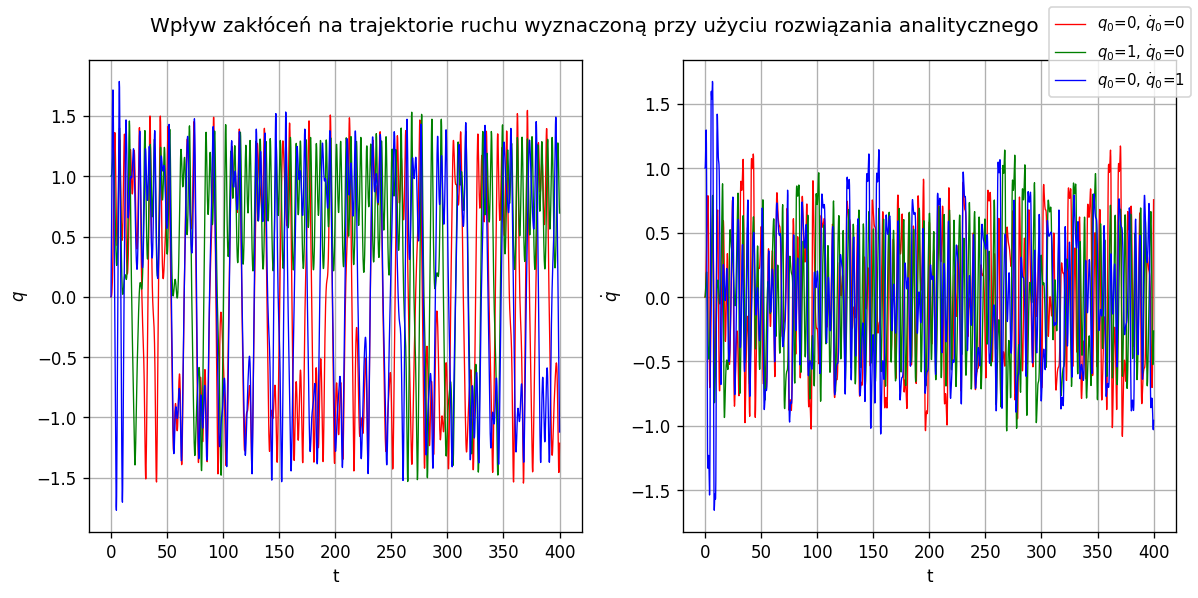

In [4]:
#WYŚWIETLENIE TRAJEKTORI (METODA ANALITYCZNA)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Wpływ zakłóceń na trajektorie ruchu wyznaczoną przy użyciu rozwiązania analitycznego')

#Położenie (kąt)
axes[0].plot(t, analitical_clean1[:, 0], 'r', linewidth=0.8, label='$q_0$=0, $\dot q_0$=0')
axes[0].plot(t, analitical_clean2[:, 0], 'g', linewidth=0.8, label='$q_0$=1, $\dot q_0$=0')
axes[0].plot(t, analitical_clean3[:, 0], 'b', linewidth=0.8, label='$q_0$=0, $\dot q_0$=1')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
fig.legend(fontsize="9", loc='upper right')
axes[0].grid()

#Prędkość (kątowa)
axes[1].plot(t, analitical_clean1[:, 1], 'r', linewidth=0.8, label='$q_0$=0, $\dot q_0$=0')
axes[1].plot(t, analitical_clean2[:, 1], 'g', linewidth=0.8, label='$q_0$=1, $\dot q_0$=0')
axes[1].plot(t, analitical_clean3[:, 1], 'b', linewidth=0.8, label='$q_0$=0, $\dot q_0$=1')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()

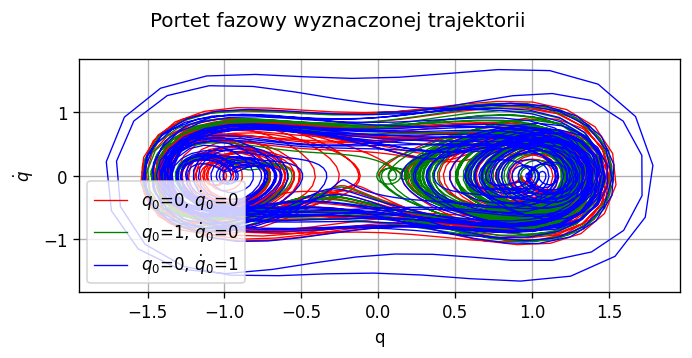

In [5]:
fig, axes = plt.subplots(1, 1, figsize=(6, 3), dpi=120)
fig.suptitle("Portet fazowy wyznaczonej trajektorii")
axes.plot(analitical_clean1[:, 0], analitical_clean1[:, 1], 'r', linewidth=0.8, label='$q_0$=0, $\dot q_0$=0')
axes.plot(analitical_clean2[:, 0], analitical_clean2[:, 1], 'g', linewidth=0.8, label='$q_0$=1, $\dot q_0$=0')
axes.plot(analitical_clean3[:, 0], analitical_clean3[:, 1], 'b', linewidth=0.8, label='$q_0$=0, $\dot q_0$=1')
axes.set_xlabel('q')
axes.set_ylabel('$\dot q$')
axes.legend()
axes.grid()

plt.tight_layout()

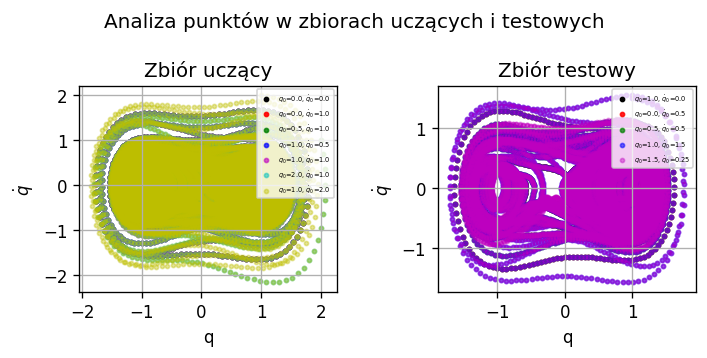

In [6]:
# Setup training and testing data
N = 2500
time_step = 0.05
x0_train = jnp.array([[0.0, 0.0], [0, 1], [0.5, 1], [1, 0.5], [1, 1], [2, 1], [1, 2]], dtype=jnp.float32)
x0_test = jnp.array([[1, 0.0], [0, 0.5], [0.5, 0.5], [1, 1.5], [1.5, 0.25]], dtype=jnp.float32)
t = jnp.linspace(0, N * time_step, num=N, dtype=jnp.float32)

# Initialize training and testing arrays
x_train = jnp.zeros([x0_train.shape[0] * N, 3])
y_train = jnp.zeros([x0_train.shape[0] * N, 2])
x_test = jnp.zeros([x0_test.shape[0] * N, 3])
y_test = jnp.zeros([x0_test.shape[0] * N, 2])


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
color=['k','r','g','b', 'm', 'c','y']
legend_train=[]
legend_test=[]

# Generate training data based on trajectories from different initial points
for i in range(x0_train.shape[0]):
    trajectory = jax.device_get(solve_analitical(x0_train[i], t))
    x_train = x_train.at[i * N:(i + 1) * N, 0:2].set(trajectory)
    x_train = x_train.at[i * N:(i + 1) * N, 2].set(t)

    accelerations = jax.vmap(analitical)(trajectory, t)
    y_train = y_train.at[i * N:(i + 1) * N, :].set(accelerations)

    axes[0].scatter(x_train[:, 0], x_train[:, 1], c=color[i], s=6, alpha=1-0.1*i)
    legend_train.append("$q_0$="+str(x0_train[i,0])+", $\dot q_0$="+str(x0_train[i,1]))

# Similarly, generate test data
for i in range(x0_test.shape[0]):
    trajectory = jax.device_get(solve_analitical(x0_test[i], t))
    x_test = x_test.at[i * N:(i + 1) * N, 0:2].set(trajectory)
    x_test = x_test.at[i * N:(i + 1) * N, 2].set(t)

    accelerations = jax.vmap(analitical)(trajectory, t)
    y_test = y_test.at[i * N:(i + 1) * N, :].set(accelerations)

    axes[1].scatter(x_test[:, 0], x_test[:, 1], c=color[i], s=6, alpha=1-0.15*i)
    legend_test.append("$q_0$="+str(x0_test[i,0])+", $\dot q_0$="+str(x0_test[i,1]))

fig.suptitle("Analiza punktów w zbiorach uczących i testowych")
axes[0].set_xlabel('q')
axes[0].set_ylabel('$\dot q$')
axes[0].set_title('Zbiór uczący')
axes[0].grid()
axes[0].legend(legend_train,fontsize="4", loc='upper right')
axes[1].set_xlabel('q')
axes[1].set_ylabel('$\dot q$')
axes[1].set_title('Zbiór testowy')
axes[1].grid()
axes[1].legend(legend_test,fontsize="4", loc='upper right')
plt.tight_layout()




In [7]:
#ARCHITEKUTRA SIECI NEURONOWEJ
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(256),
    stax.Softplus,
    stax.Dense(256),
    stax.Softplus,
    stax.Dense(1),
)

#Funkcja modelująca lagrangian (wyjście sieci neuronowej)
#Argumenty:
#   params - parametry sieci neuronowej
#   q, q_t - wektor wartości wejściowych dla sieci (położenie, przyśpieszenie)
#Zwraca:
#   lagrangian - wartość lagrangianu dla danego wektora stanu
def learned_lagrangian(params):
    def lagrangian(state, t):
        t = jnp.expand_dims(t, axis=-1) if t.ndim == 0 else t.reshape(-1)
        input = jnp.concatenate([state, t], axis=-1)
        return jnp.squeeze(nn_forward_fn(params, input), axis=-1)
    return lagrangian


def equation_of_motion(lagrangian, state, t=None):
    #Rozdzilenie danych startowych na położenia i prędkości
    q, q_t = jnp.split(state, 2, axis=-1)
    #Obliczanie przyśpieszenia na podstawie lagrangianu
    q_tt = jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t)) @ (
        jax.grad(lagrangian, 0)(q, q_t)
        - jax.jacfwd(jax.grad(lagrangian, 1), 0)(q, q_t) @ q_t)
    return jnp.concatenate([q_t, q_tt], axis=-1)




#Funkcja wyznaczająca trajektorię ruchu przy użyciu Lagrangianu zamodlowanego za pomocą sieci neuronowej
#Argumenty funkcji:
#   -params        - Parametry sieci neuronowej
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#Zwraca:
#   Wektor trajektori ruchu w zależności od czasu
@partial(jax.jit, backend='cpu')
def solve_lagrangian(params, initial_state, times):
  return odeint(partial(equation_of_motion, learned_lagrangian(params)),
                  initial_state, times, rtol=1e-10, atol=1e-10)
  
  
#Funkcja ma za zadanie obliczenie przyśpieszenia na podstawie aktualnego stanu
#(położenie i przyśpieszenie) przy użyciu lagrangianu zamodelowanego przez sieć LNN.
#Argumenty funkcji:
#   -params     - Parametry sieci.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości [q, q_t].
#Zwracane:  Przyśpieszenie wynikającego z aktulanego wektora stanu.  
def acceleration_learned(params, initial_state, times):
  acc = partial(equation_of_motion, learned_lagrangian(params))
  return acc(initial_state, times)[1]


#DEFINICJA BŁĘDU DLA SIECI
#Argumenty:
#   params  - parametry sieci neuronowej
#   input   - wektor stanu i czasu [położenie, prędkość, czas]
#   target  - oczekiwany wektor wyjściowy sieci [prędkość, przyśpieszenie]
@partial(jax.jit, backend='cpu')
def MSE_loss(params, input, targets):
  state = input[:, :2]
  t = input[:, 2]
  preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state, t)
  return jnp.mean((preds- targets) ** 2)




#Funkcja zamieniająca losowe elementy 2 wektorów w ten sam sposób.
#Argumenty:
#   a, b - Wektory, które mają zostać przemieszane.
#Zawracane:
#   a, b - Przetasowane wektory.
def shuffle(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

In [8]:
%%time
#UCZENIE SIECI NEURONOWEJ



Training=True      #Uczenie sieci
Epochs=1000       #Maksymalna liczba epok
StopError=0.001      #Wartość błędu MSE dla zbioru testowego, przy której uczenie zostanie szybciej zakończone
#!!!!WAZNE - STOP ERROR MAX 0.005, PONIZEJ PRZEUCZENIE
Learning_rate=1e-3  #Współczynnik uczenia
Batch_size= 32


train_error=[]      #Wektor błędów MSE dla zbioru uczącego
test_error=[]       ##Wektor błędów MSE dla zbioru testowego

#Wektory wag
w1=[]
w2=[]
w3=[]
w4=[]

#Ścieżka dla pliku przechowującego parametry sieci
config = {"ckpt_path": "Checkpoints"}

#Inicjalizacja parametrów sieci
rng = jax.random.PRNGKey(0)
output_shape, params_initial = init_random_params(rng, (-1, 2))

#Wybór optymalizotra sieci ADAM
init, update, get_params = optimizers.adam(step_size=Learning_rate)
update = jax.jit(update)
get_params = jax.jit(get_params)


#Wykonanie uczenia sieci
if(Training):

    best_error = float('inf')

    opt_state = init(params_initial)
    for i in range(Epochs):
        #Realizacja minibatcha
        x_train, y_train = shuffle(x_train, y_train)
        start=0
        while start < x_train.shape[0]:
            #Podział danych na batche
            end = start+Batch_size
            if end > x_train.shape[0]:
                end = x_train.shape[0]
            x_batch = x_train[start:end, :]
            y_batch = y_train[start:end, :]

            #Obliczenie błędu MSE i optymalizacja wag
            params = get_params(opt_state)
            grad = jax.grad(MSE_loss)(params, x_batch, y_batch)
            opt_state = update(i, grad, opt_state)

            start += Batch_size


        #Zapisanie błędu na podstawie zbioru uczącego i testowego w każdej epoce
        train_error.append(MSE_loss(params, x_train, y_train))
        test_error.append(MSE_loss(params, x_test, y_test))

        #Zapamiętywanie najlepszych parametrów sieci
        if test_error[-1]<best_error:
            best_error = test_error[-1]
            best_params = params

        #Zapisywanie pewnych wag
        w1.append(params[2][0][1][2])
        w2.append(params[0][1][2])
        w3.append(params[2][0][1][3])
        w4.append(params[0][1][1])

        #Wcześciejsze kończenie uczenia
        if test_error[-1]<=StopError:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
            break

        #Wyświetlanie informacji o postępie uczenia
        if i%1==0:
            print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}, best_loss={best_error:.6f}")
    
    #Wybór najlepszych parametrów
    params = best_params

    #Zapisanie parametrów do pliku
    pickle.dump(params, open(os.path.join(config["ckpt_path"], "Duffing.pkl"), "wb"))

#Brak uczenia - odczyt parametrów z pliku
else:
    params = pickle.load(open(os.path.join(config["ckpt_path"], "Duffing.pkl"), "rb"))
    #opt_state = optimizers.pack_optimizer_state(params)

iteration=0, train_loss=2.941168, test_loss=2.686408, best_loss=2.686408
iteration=1, train_loss=1.403970, test_loss=1.221204, best_loss=1.221204
iteration=2, train_loss=1.066978, test_loss=0.898488, best_loss=0.898488
iteration=3, train_loss=1.029929, test_loss=0.827276, best_loss=0.827276
iteration=4, train_loss=1.008528, test_loss=0.803993, best_loss=0.803993
iteration=5, train_loss=0.993247, test_loss=0.790607, best_loss=0.790607
iteration=6, train_loss=0.977537, test_loss=0.773626, best_loss=0.773626
iteration=7, train_loss=0.961263, test_loss=0.759597, best_loss=0.759597
iteration=8, train_loss=0.953271, test_loss=0.737366, best_loss=0.737366
iteration=9, train_loss=0.926602, test_loss=0.719148, best_loss=0.719148
iteration=10, train_loss=0.902219, test_loss=0.707308, best_loss=0.707308
iteration=11, train_loss=0.878705, test_loss=0.684238, best_loss=0.684238
iteration=12, train_loss=0.854577, test_loss=0.682477, best_loss=0.682477
iteration=13, train_loss=0.834859, test_loss=0.6

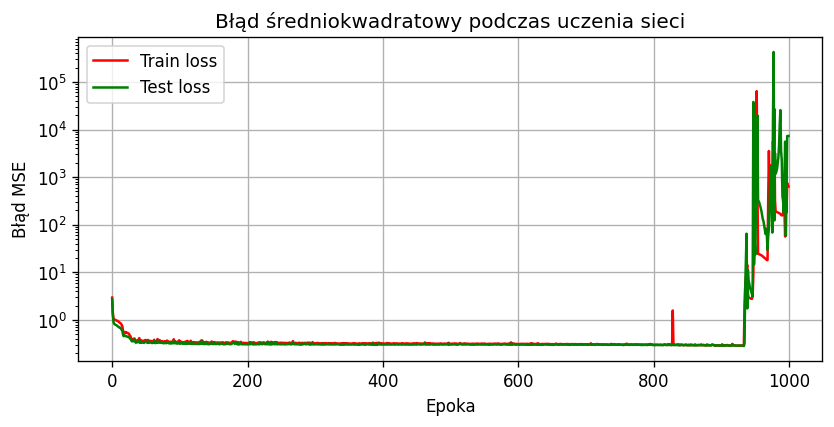

In [9]:
#WIZUALIZACJA BŁĘDU MSE PODCZAS UCZENIA SIECI

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_error[:], 'r', label='Train loss')
plt.plot(test_error[:], 'g', label='Test loss')
plt.yscale('log')
plt.title('Błąd średniokwadratowy podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Błąd MSE")
plt.grid()
plt.legend() 
plt.show()

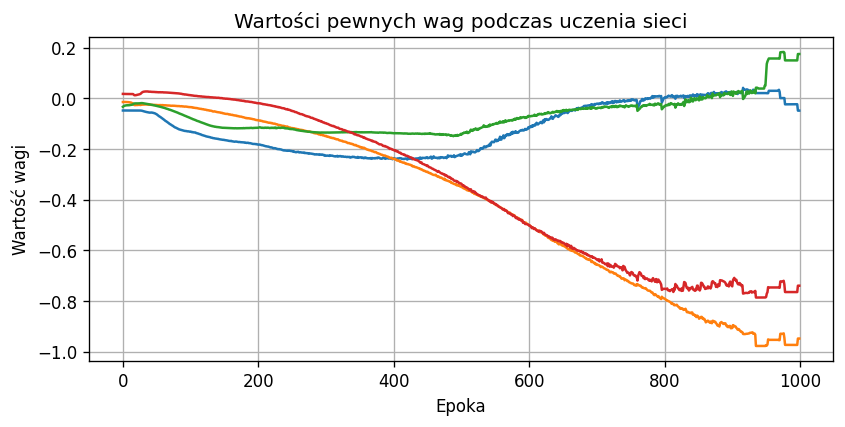

In [10]:
#WIZUALIZACJA ZMIAN WYBRANYCH WAG PODCZAS UCZENIA SIECI

plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(w1[:])
plt.plot(w2[:])
plt.plot(w3[:])
plt.plot(w4[:])
plt.title('Wartości pewnych wag podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Wartość wagi")
plt.grid()
plt.show()

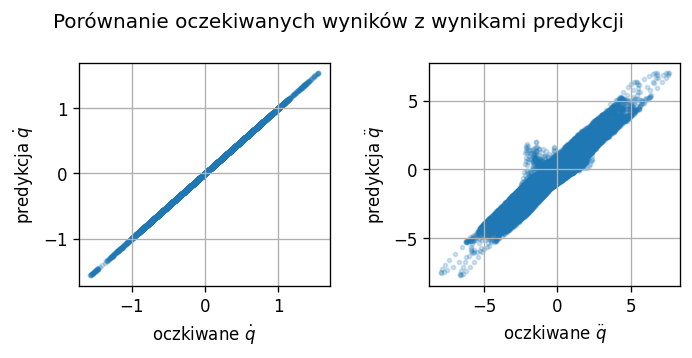

In [11]:
#TEST PREDYKCJI SIECI

#Obliczenie predykcji sieci (wartość wyjściowa) na podstawie zbioru testowego
state=x_test[:,:2]
t=x_test[:,2]
y_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state, t)

x_test = jax.device_get(x_test)
y_test = jax.device_get(y_test)
y_pred = jax.device_get(y_pred)

#Wizualizacji wyników
fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
fig.suptitle("Porównanie oczekiwanych wyników z wynikami predykcji")
axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=0.2)
axes[0].set_xlabel('oczkiwane $\dot q$')
axes[0].set_ylabel('predykcja $\dot q$')
axes[0].grid()
axes[1].scatter(y_test[:, 1], y_pred[:, 1], s=6, alpha=0.2)
axes[1].set_xlabel('oczkiwane $\ddot q$')
axes[1].set_ylabel('predykcja $\ddot q$')
axes[1].grid()
plt.tight_layout()

In [12]:
#OBLICZENIE BŁĘDU WZGLĘDNEGO PREDYKCJI

#Zakresy prędkości i położenia
q=jnp.arange(-2, 2, 0.1, dtype=jnp.float32)
q_t=jnp.arange(-2, 2, 0.1, dtype=jnp.float32)



True_value = np.zeros([len(q), len(q_t)],dtype=jnp.float32)
Pred_value = np.zeros([len(q), len(q_t)],dtype=jnp.float32)
Error = np.zeros([len(q), len(q_t)],dtype=jnp.float32)



for i in range (len(q)):
    for j in range(len(q_t)):
        True_value[i,j] = analitical(jnp.array([q[i], q_t[j]]),t=0)[1]                #Wartość rzczywista
        Pred_value[i,j] = acceleration_learned(params, jnp.array([q[i], q_t[j]]), times=0)           #Predykcja
        Error[i,j] = np.abs(True_value[i,j]-Pred_value[i,j])/np.abs(True_value[i,j])*100    #Błąd (wartość bezwlędna z różnicy)

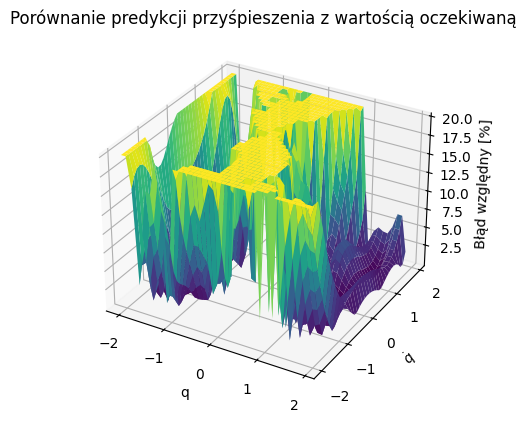

<Figure size 640x480 with 0 Axes>

In [13]:
#WIZUALIZACJA WZGLĘDNEGO BŁĘDU PROCENTOWEGO PREDYKCJI

q, q_t = np.meshgrid(q, q_t)
Error = np.transpose(Error)

Error = np.where(Error>20, 20, Error)

#Wizualizacja
#%matplotlib qt5
fig = plt.figure()
axes = fig.add_subplot(projection='3d')

axes.set_title("Porównanie predykcji przyśpieszenia z wartością oczekiwaną")
axes.set_xlabel('q')
axes.set_ylabel('$\dot q$')
axes.set_zlabel("Błąd względny [%]")
axes.grid()

axes.plot_surface(q, q_t, Error, cmap='viridis')
plt.show()
plt.tight_layout()
%matplotlib inline

CPU times: user 4.16 s, sys: 10.2 ms, total: 4.17 s
Wall time: 4.16 s
CPU times: user 313 ms, sys: 19.5 ms, total: 332 ms
Wall time: 326 ms


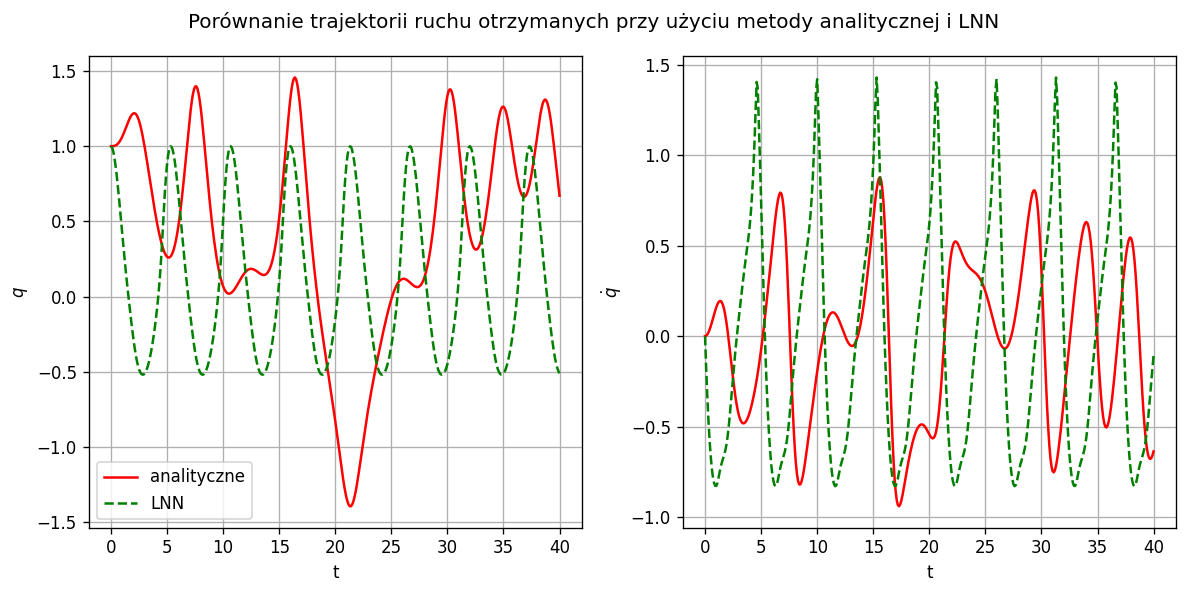

In [14]:
#TEST WYZNACZENIA TRAJEKTORI RUCHU PRZY UŻYCIU SIECI NEURONOWEJ

#Punkt startowy
x0 = jnp.array([1,0], dtype=np.float32)
#Wektor czasu
t = np.linspace(0, 40, num=401, dtype=np.float32)

#Wyznaczenie trajektori przy użyciu sieci
%time lagrangian_trajectory = jax.device_get(solve_lagrangian(params, x0, t))

#Wyznaczenie trajektori metodą analityczną
%time analitical_trajectory = jax.device_get(solve_analitical(x0, t))


#WIZUALIZACJA
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie trajektorii ruchu otrzymanych przy użyciu metody analitycznej i LNN')


axes[0].plot(t, analitical_trajectory[:, 0], 'r', label='analityczne')
axes[0].plot(t, lagrangian_trajectory[:, 0], 'g--', label='LNN')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()


axes[1].plot(t, analitical_trajectory[:, 1], 'r', label='analityczne')
axes[1].plot(t, lagrangian_trajectory[:, 1], 'g--', label='LNN')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()